In [1]:
import time
import os
import math
import numpy as np
import cv2
import pandas as pd
import pyautogui as pa
import shutil
import imageio
from PIL import Image, ImageDraw

from lib.auto_GUI.auto_GUI_base import AutoGUIBase
from lib.auto_GUI.auto_DAT import AutoDAT
from lib.auto_GUI.auto_PhotoZ import AutoPhotoZ
from lib.analysis.laminar_dist import *
from lib.file.TIF import *
from lib.analysis.align import ImageAlign
from lib.utilities import *

###########################################
# Make a series of 1-frame measure windows from PhotoZ into a movie
# Asks user to annotate DIC/Fluorescence images for electrode + layer and barrel boundaries
#       Puts this metadata into ROI .dat files
# Uses DIC-to-ZDA frame mapping (rotation and scaling) to annotate the PhotoZ frames
# Uses autoPhotoZ to take frame images for move
#  - 8/24/23: 
#        Support any number of barrels.
#        add ROI generation: layer/barrel ROIs
###########################################

In [2]:
# Load data, not from Drive for Desktop since PhotoZ complains about loading zda from Drive
google_drive_dir = "G:/.shortcut-targets-by-id/1afwzLrN3AQQPbJ1PQiZlKAb1Bijc5qln/Choosing trajectories/"
data_dir = "C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/"
start_frame = 94
movie_length = 27
camera_program = 4

# annotation settings
skip_draw_annotations = False  # don't draw any new annotations

# Movie maker settings
disable_photoZ_interact = True
initialize_photoZ = False
clean_scratch_files = False  # clean up SNR maps
replace_existing_frame_pngs = False
disable_google_drive_interact = True
image_border_width = 8
image_scaling = 7  # pixels of image per array diode pixel
electrode_marker_radius = 4

In [3]:
# set up PhotoZ (open it manually)
aPhz = AutoPhotoZ(data_dir=data_dir)
if initialize_photoZ and not disable_photoZ_interact:
    aPhz.prepare_photoZ()
if not disable_photoZ_interact:
    aPhz.click_normalize_2_array_max()
pa.alert("Please disable trace overlay and maximize PhotoZ before continuing.")

'OK'

01_01_03
1 1
Number of shapes drawn: 1
Number of shapes drawn: 6


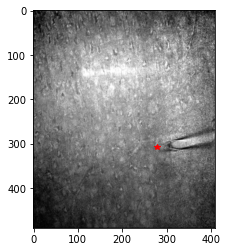

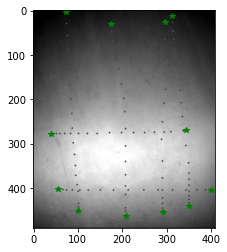

Electrode point: [53, 49]
Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/06-26-23/selected_zda//analysis01_01_03/electrode.dat
Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/06-26-23/selected_zda//analysis01_01_03/corners_layer.dat
Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/06-26-23/selected_zda//analysis01_01_03/corners_barrel.dat
Wrote files to C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/06-26-23/selected_zda//analysis01_01_03/
[3372, 3665, 4653, 5114]
[5220, 580, 5479, 998, 5494, 1099, 5424, 1022]
[ 0.  2.  3. 32. 34. 35. 48. 50. 51. 56. 58. 59. 60. 62. 63.]


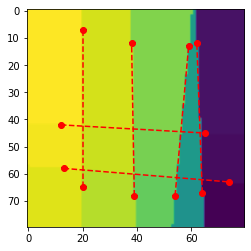

NameError: name 'notImplementedError' is not defined

In [9]:
# First ask user to annotate some images with Electrode loc and L4 boundaries and layer text placement
# based on DIC-to-ZDA_Alignment script
if not skip_draw_annotations:
    for subdir, dirs, files in os.walk(data_dir):
        if 'notUsable' in subdir:
            continue
        if 'mm_hidden' in subdir:
            continue
        if 'dic' in dirs and 'selected_zda' in dirs:
            dic_dir = subdir + "/dic/"
            selected_zda_dir = subdir + "/selected_zda/"
            already_drawn_slic_loc = {}

            # take selected zda and expand into separate subdir for each zda file
            for zda_file in os.listdir(selected_zda_dir):
                if zda_file.endswith('.zda'):
                    rec_id = zda_file.split('.')[0]
                    slic_id, loc_id, _ = [int(x) for x in rec_id.split("_")]
                    print(rec_id)
                    # output dir
                    output_dir = selected_zda_dir + "/analysis" + rec_id + "/"
                    try:
                        os.makedirs(output_dir)
                    except Exception as e:
                        pass

                    # read in 8-bit single TIF images to array, apply same cropping/binning
                    image_data = {}
                    cam_settings = CameraSettings().get_program_settings(camera_program)
                    binning = int(2048 / 400) # if want size similar to RLI
                    TIFLoader(dic_dir, 
                              cam_settings, 
                              binning, 
                              crop=False, 
                              flip_horiz=True).load_files(image_data, slice_target=slic_id)

                    # align RLI and DIC and record the RLI's image boundaries within the DIC image.
                    dic_coordinates = [[8, 6], [80, 12], [2, 69], [76, 74]]
                    img_aligner = ImageAlign(dic_coordinates)

                    for slic in image_data:
                        for loc in image_data[slic]:

                            if slic != slic_id or loc != loc_id:
                                continue

                            # if already drawn, no need to ask user again
                            if str(slic_id)+"_"+str(loc_id) in already_drawn_slic_loc:
                                # just copy them over
                                src_dir = already_drawn_slic_loc[str(slic_id)+"_"+str(loc_id)]
                                electrode_file = src_dir + "electrode.dat"
                                corners_layer_file = src_dir + "corners_layer.dat"
                                corners_barrel_file = src_dir + "corners_barrel.dat"
                                shutil.copy(electrode_file, output_dir + "electrode.dat")
                                shutil.copy(corners_layer_file, output_dir + "corners_layer.dat")
                                shutil.copy(corners_barrel_file, output_dir + "corners_barrel.dat")
                                continue

                            print(slic, loc)

                            # DICs
                            fluor = None
                            if 'f' in image_data[slic][loc]:
                                fluor = image_data[slic][loc]['f']
                            elif 'fe' in image_data[slic][loc]:
                                fluor = image_data[slic][loc]['fe']
                            # img = image_data[slic][loc]['i']

                            dic_electrode = None
                            if 'e' in image_data[slic][loc]:
                                dic_electrode = image_data[slic][loc]['e']
                            else:
                                dic_electrode = fluor

                            dic_electrode = np.array(dic_electrode, dtype=np.uint8)
                            orig_arr_shape = dic_electrode.shape

                            # ask user to select site of stim and layer/barrel borders
                            dic_electrode, coords_electrode, dic_layers, coords_layers = img_aligner.draw_on_images_wrapper(
                                dic_electrode, fluor)
                            dic_electrode = np.array(dic_electrode)
                            dic_layers = np.array(dic_layers)

                            plt.imshow(dic_electrode, cmap='gray')
                            x_el, y_el = coords_electrode['electrode']
                            plt.plot(x_el, y_el, marker="*", color='red')
                            plt.show()
                            
                            plt.imshow(dic_layers, cmap='gray')
                            for key_pt in coords_layers:
                                if "_axis" in key_pt:
                                    for pt in coords_layers[key_pt]:
                                        x, y = pt
                                        plt.plot(x, y, marker="*", color='green')
                            plt.show()

                            try:
                                os.makedirs(output_dir)
                            except OSError:
                                pass

                            # transform coordinates -- Actual alignment work done here
                            coords_electrode = img_aligner.transform_from_dic_coordinates(coords_electrode, orig_arr_shape)
                            coords_layers = img_aligner.transform_from_dic_coordinates(coords_layers, orig_arr_shape)
                            coordinates = coords_electrode | coords_layers

                            # write electrode and corners to file
                            electrode_file = output_dir + "electrode.dat"
                            corners_layer_file = output_dir + "corners_layer.dat"
                            corners_barrel_file = output_dir + "corners_barrel.dat"
                            img_aligner.write_shapes_to_files(coordinates,
                                                              electrode_file,
                                                              corners_layer_file,
                                                              corners_barrel_file,
                                                              preserve_initial_order=True)
                            print("Wrote files to", output_dir)
                            
                            ############################################
                            # Create ROIs for each layer/barrel division
                            ############################################
                            # read barrel and layer axes data back in
                            barrel_layer_axes = []  # going to be a list of Line objects, first 2 are layer boundaries, rest are barrel boundaries
                            for la_file in [corners_layer_file, corners_barrel_file]:
                                with open(la_file, 'r') as f:
                                    lines = f.readlines() 
                                roi_px_ct = int(lines[2]) - 1 
                                corners = [int(x) for x in lines[4:]] # the last lines are diode numbers of corners
                                if len(corners) != roi_px_ct:
                                    raise Exception("Likely an error processing corners. Expected " + 
                                                    str(roi_px_ct) + " pixels.")
                                layer_axes = LayerAxes(corners[:4], verbose=False, obey_initial_order=True)
                                laminar_axis, laminar_axis_2 = layer_axes.get_layer_axes()
                                barrel_layer_axes.append(laminar_axis)
                                barrel_layer_axes.append(laminar_axis_2)
                                
                                print(corners)
                                rest_of_corners = LaminarROI(corners[4:]).get_points()
                                for j in range(0, len(rest_of_corners), 2):
                                    if len(rest_of_corners) > j+1:
                                        barrel_layer_axes.append(Line(rest_of_corners[j], rest_of_corners[j+1]))

                            # Now we will divide into L2/3, L4, L5 and barrels
                            w, h = LaminarROI([]).get_dimensions()
                            px_map = np.zeros((w, h))
                            incrementer = 1
                            for axis in barrel_layer_axes:
                                for i in range(w):
                                    for j in range(h):
                                        if axis.is_point_left_of_line([i, j]):
                                            px_map[i, j] += incrementer
                                incrementer *= 2
                            n_unique_rois = np.unique(px_map)  # should match the number of ROIs expected
                            print(n_unique_rois)
                                    
                            plt.clf()
                            plt.imshow(np.transpose(px_map))
                            for axis in barrel_layer_axes:
                                p1, p2 = axis.get_line_repr()
                                plt.plot(p1[0], p1[1], marker="*", color='green')
                                plt.plot(p2[0], p2[1], marker="*", color='blue')
                                plt.plot([p1[0], p2[0]], [p1[1], p2[1]], 'ro', linestyle="--")
                            plt.show()
                            
                            # Then we will take this Pixel classification map and turn into ROIs
                            raise notImplementedError
                            

                            # mark this slice/loc already drawn 
                            already_drawn_slic_loc[str(slic_id)+"_"+str(loc_id)] = output_dir
                    image_data.clear()

In [ ]:
current_color_bound_setting = 1.0
for subdir, dirs, files in os.walk(data_dir):
    if 'notUsable' in subdir:
        continue
    if 'mm_hidden' in subdir:
        continue
    if 'dic' in dirs and 'selected_zda' in dirs:
        print(subdir)
        dic_dir = subdir + "/dic/"
        selected_zda_dir = subdir + "/selected_zda/"

        for zda_file in os.listdir(selected_zda_dir):
            if zda_file.endswith('.zda'):

                rec_id = zda_file.split('.')[0]
                print(rec_id)
                # movie dir
                output_dir = selected_zda_dir + "/analysis" + rec_id + "/"
                try:
                    os.makedirs(output_dir)
                except Exception as e:
                    pass

                # determine if we are even missing any jpg'd frames
                need_to_open_zda = True
                for frame in range(start_frame, start_frame + movie_length):
                    filename = output_dir + str(frame) + ".jpg"
                    if not os.path.exists(filename):
                        need_to_open_zda = True
                        break
                if not need_to_open_zda and not replace_existing_frame_pngs:
                    continue

                recording_max_snr = 20.0  # gets changed

                if not disable_photoZ_interact:
                    aPhz = AutoPhotoZ(data_dir=selected_zda_dir)
                    # open the PhotoZ file
                    aPhz.select_PhotoZ()

                    print("\n\nOpening", zda_file)
                    aPhz.open_zda_file(selected_zda_dir + "/" + zda_file)

                    # estimate the SNR max across all frames
                    aPhz.set_measure_window(start_frame, movie_length)
                    filename = aPhz.save_background()
                    print("Saved intermed_snr_df file:", filename)
                    if filename is not None:  # otherwise, sticks with default rec max of 20

                        # open Data.dat and read in the array max
                        intermed_snr_df = pd.read_csv(filename, 
                                                      sep='\t', 
                                                      header=None, 
                                                      names=['Index',  'Values'])
                        recording_max_snr = intermed_snr_df['Values'].max()

                        recording_max_snr *= 1.05  # 5% higher for headroom
                        recording_max_snr = round(recording_max_snr, 2)
                        if clean_scratch_files:
                            try:
                                os.remove(filename)
                            except Exception as e:
                                print("Could not remove", filename)
                                print(e)

                    # set the normalization to be consistent across entire video
                    aPhz.set_color_upper_bound(recording_max_snr, current_color_bound_setting)
                    print("Moved color upper bound from", current_color_bound_setting, "to", recording_max_snr)
                    current_color_bound_setting = recording_max_snr

                    # set measure window width to 1
                    aPhz.set_measure_window(None, 1)

                ##### Get frame annotation: layer and stim markings, and store #####

                # file conventions across
                electrode_file = output_dir + "/electrode.dat"
                corners_layer_file = output_dir + "/corners_layer.dat"
                corners_barrel_file = output_dir + "/corners_barrel.dat"
                annotations_enabled = all([os.path.exists(f) for f in [electrode_file, 
                                                                       corners_layer_file, 
                                                                       corners_barrel_file]])

                def array_point_to_image_pixel(arr_pt):
                    x_arr, y_arr = arr_pt
                    return [image_border_width + image_scaling * x_arr, 
                            image_border_width + image_scaling * y_arr]

                if annotations_enabled:
                    # read in electrode location
                    with open(electrode_file, 'r') as f:
                        lines = f.readlines()
                    stim_pt = int(lines[-1]) # last line is always electrode location
                    aux_obj = LaminarROI([stim_pt]).get_points()
                    stim_pt = aux_obj[0]  # should be a list of len 2, representing px location [x, y]
                    print("Stim point:", stim_pt)
                    stim_img_px = array_point_to_image_pixel(stim_pt)
                    stim_xy = (stim_img_px[0] - electrode_marker_radius, 
                               stim_img_px[1] - electrode_marker_radius, 
                               stim_img_px[0] + electrode_marker_radius, 
                               stim_img_px[1] + electrode_marker_radius)
                    # read in corners files
                    la_corners = {corners_layer_file: {},
                                  corners_barrel_file: {}}
                    for la_file in [corners_layer_file, corners_barrel_file]:
                        with open(la_file, 'r') as f:
                            lines = f.readlines() 
                        corners = [int(x) for x in lines[4:]] # the last 4 lines are diode numbers of corners
                        layer_axes = LayerAxes(corners)
                        laminar_axis, laminar_axis_2 = layer_axes.get_layer_axes()
                        print("laminar axis unit vectors:", laminar_axis.get_unit_vector(), 
                              laminar_axis_2.get_unit_vector())

                        end = array_point_to_image_pixel(laminar_axis.get_end_point())
                        end2 = array_point_to_image_pixel(laminar_axis_2.get_end_point())
                        start = array_point_to_image_pixel(laminar_axis.get_start_point())
                        start2 = array_point_to_image_pixel(laminar_axis_2.get_start_point())
                        la_corners[la_file]["line_loc"] = [start + end, start2 + end2]
                        la_corners[la_file]["text_loc"] = (int((end[0] + end2[0]) / 2), 
                                                           int((end[1] + end2[1]) / 2))


                images = []
                img_filenames = []
                for frame in range(start_frame, start_frame + movie_length):
                    filename = output_dir + str(frame) + ".jpg"
                    if replace_existing_frame_pngs or not os.path.exists(filename):
                        # change frame
                        if not disable_photoZ_interact:
                            aPhz.set_measure_window(frame, None)

                            # export this frame
                            aPhz.save_map_jpeg(filename)
                            print("File created:", filename)

                    if annotations_enabled:
                        # draw electrode location on image <filename>
                        image = Image.open(filename)
                        draw = ImageDraw.Draw(image)
                        draw.ellipse(stim_xy, outline='red', width=2)
                        # read in corners files
                        for la_file in [corners_layer_file, corners_barrel_file]:
                            draw.line(la_corners[la_file]["line_loc"][0], fill='white', width=2)
                            draw.line(la_corners[la_file]["line_loc"][1], fill='white', width=2)
                            if la_file == corners_layer_file:
                                draw.text(la_corners[la_file]["text_loc"], "L4", anchor="ms")
                        # PIL image write back
                        image.save(filename)

                    try:
                        images.append(imageio.imread(filename))
                        img_filenames.append(filename)
                    except Exception as e:
                        pass

                # create gif
                created_movie = False
                try:
                    imageio.mimsave(output_dir + rec_id + 'movie.gif', images)
                    print("CREATED MOVIE:", rec_id + 'movie.gif')
                    created_movie = True
                    if clean_scratch_files:
                        for img_file in img_filenames:
                            os.remove(img_file)
                except Exception as e:
                    if not created_movie:
                        print("Not creating movie for " + rec_id)
                    print(e)

## 